In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import zipfile

In [ ]:
df = pd.read_csv('/content/soil spectra.csv')
print("CSV file imported successfully.")

CSV file imported successfully.


###  Function: `prepare_spider_data`

This function normalizes a 1D spectrum, closes the polygon loop, creates a radial grid, interpolates the spectrum on the grid, and generates a mask for values outside the polygon. These outputs are suitable for coloring/filling under the curve in a radar (spider) plot.

---

#### **Parameters**
- **`values`** : *array-like of shape (N,)*  
  The 1D spectrum values (e.g., intensity measurements for each spectral variable).

- **`r_steps`** : *int, default=200*  
  Number of radial points to create between 0 and the maximum normalized value.  
  Determines the radial resolution of the grid used for coloring.

---

#### **Returns**
- **`theta`** : *ndarray of shape (N+1,)*  
  Angular coordinates for each point in the spectrum, from 0 to 2π, with an extra point to close the polygon loop.

- **`values_norm`** : *ndarray of shape (N+1,)*  
  Normalized spectrum values scaled between 0 and 1, with an extra value appended to close the polygon.

- **`T`** : *ndarray of shape (r_steps, N+1)*  
  2D grid of angular coordinates created by `meshgrid`.

- **`R`** : *ndarray of shape (r_steps, N+1)*  
  2D grid of radial coordinates created by `meshgrid`, ranging from 0 to 1.

- **`Z`** : *ndarray of shape (r_steps, N+1)*  
  Interpolated intensity values mapped to the radial grid, with all points outside the polygon set to NaN.

- **`masked`** : *ndarray of shape (r_steps, N+1), dtype=bool*  
  Boolean mask indicating which points in the radial grid are **outside the polygon**.  
  `True = outside`, `False = inside`.

---

#### **Notes**
- Normalization ensures all spectrum values are scaled to `[0, 1]` while preserving relative peak differences.  
- The mask allows plotting libraries (e.g., `pcolormesh`) to fill **only the area under the polygon**, leaving outside points transparent.  
- This function prepares data for spider plots but does **not** perform the actual plotting.


In [ ]:
def prepare_spider_data(values, r_steps=200):
    # Convert input to numpy array
    values = np.asarray(values, dtype=float)
    N = len(values)

    # 1. Normalize the spectrum (scale to 0-1)
    values_norm = values / values.max()

    # 2. Close the polygon loop
    values_norm = np.append(values_norm, values_norm[0])
    theta = np.linspace(0, 2 * np.pi, N + 1)

    # 3. Build a radial grid
    r = np.linspace(0, 1, r_steps)
    T, R = np.meshgrid(theta, r)

    # 4. Interpolate spectrum along angular grid
    V = np.interp(T, theta, values_norm)

    # 5. Mask points outside the polygon
    masked = R > V
    Z = V.copy()
    Z[masked] = np.nan

    return theta, values_norm, T, R, Z, masked


In [ ]:
def plot_spider(theta, values_norm, T, R, Z, save_path=None):
    fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(6,6))

    # Fill under the curve
    ax.pcolormesh(T, R, Z, cmap='viridis', shading='gouraud', vmin=0, vmax=1)

    # Outline of the polygon
    ax.plot(theta, values_norm, color='black', lw=2)

    # Clean styling
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(False)
    ax.set_frame_on(False)
    ax.set_ylim(0, 1)
    ax.set_facecolor('white')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

✅ All plots saved and zipped into spider_plots.zip


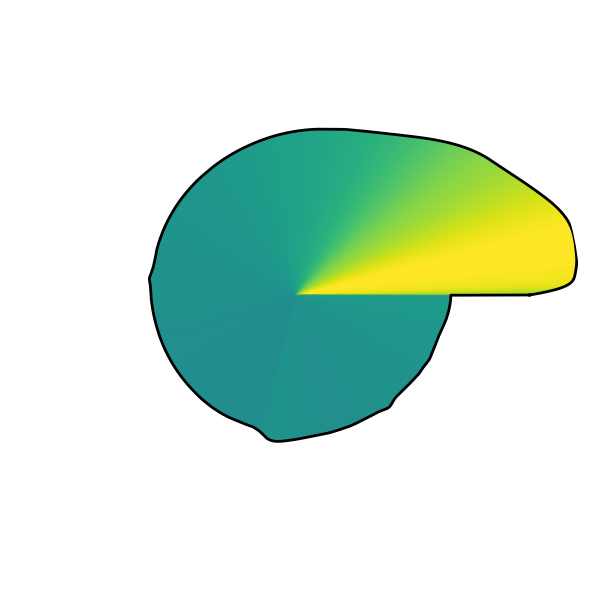

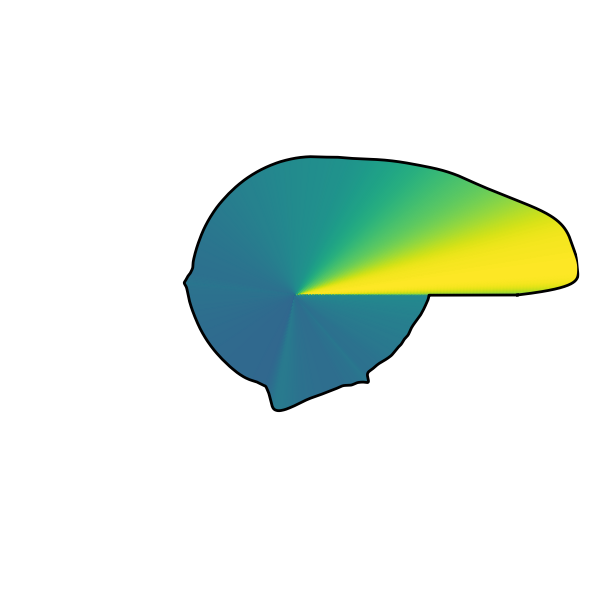

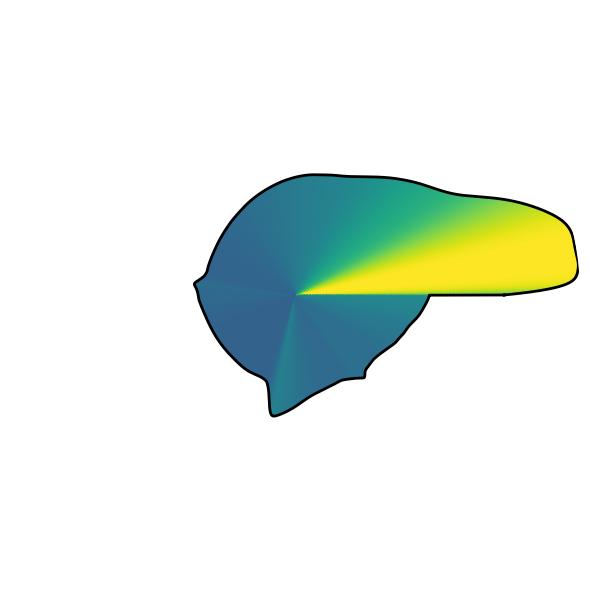

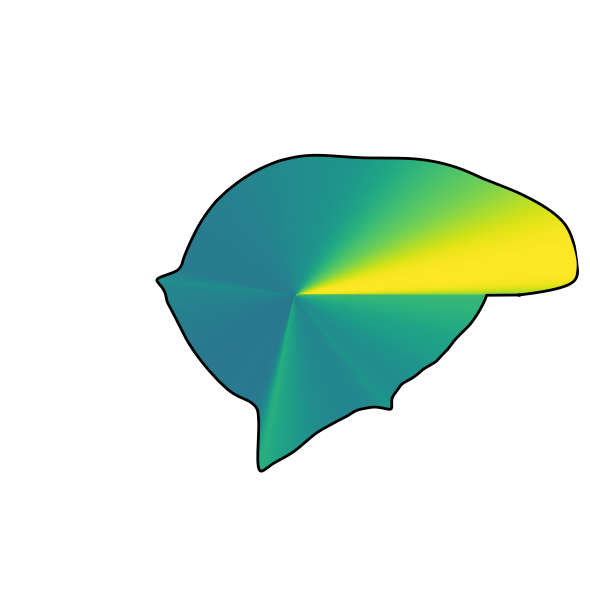

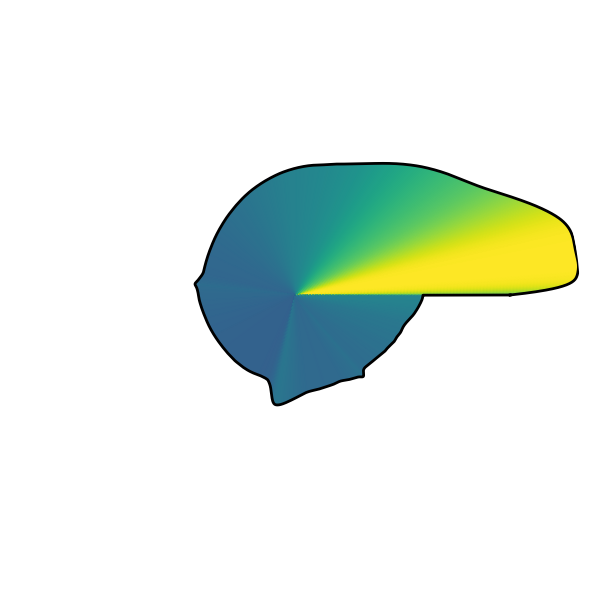

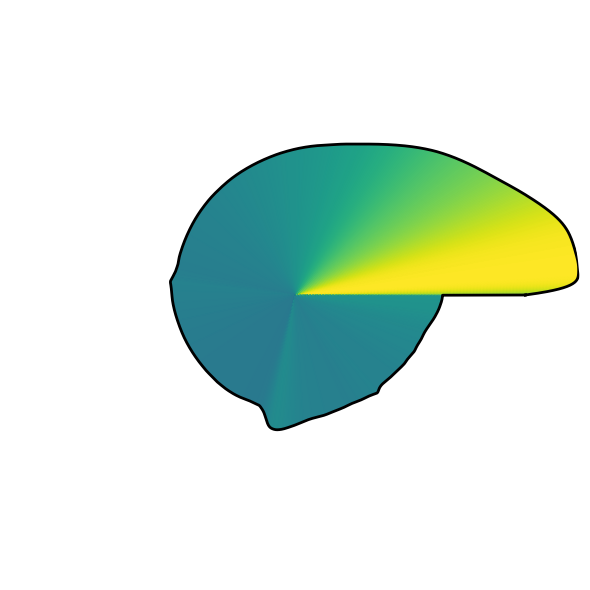

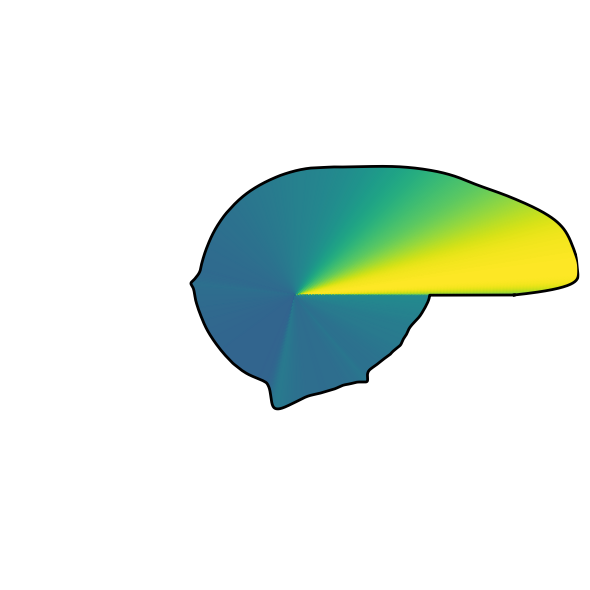

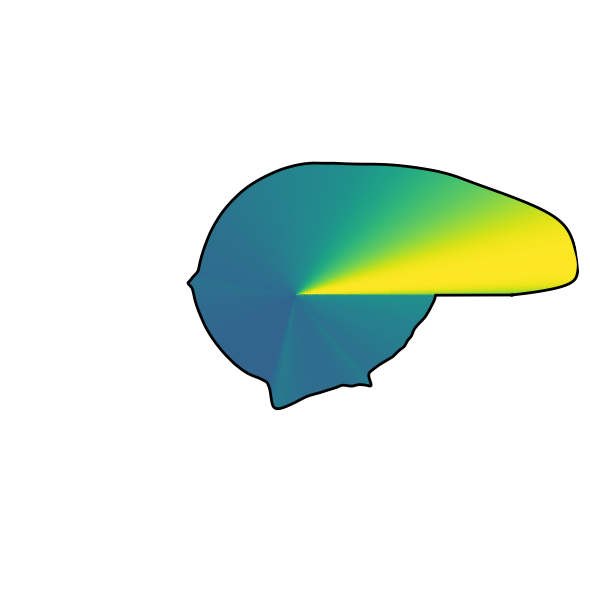

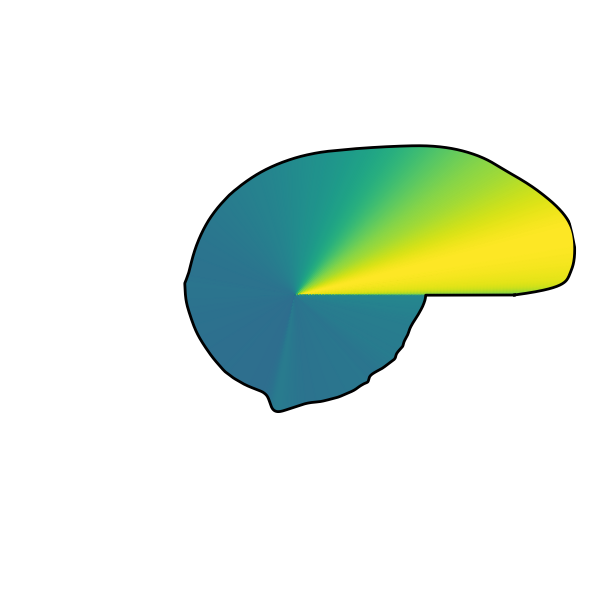

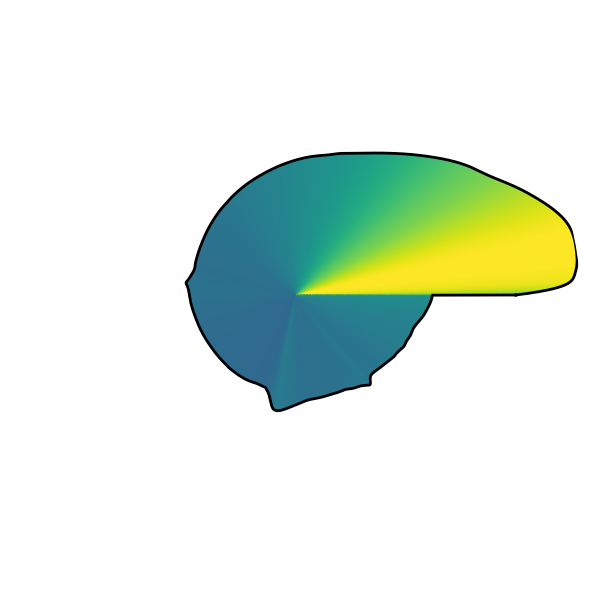

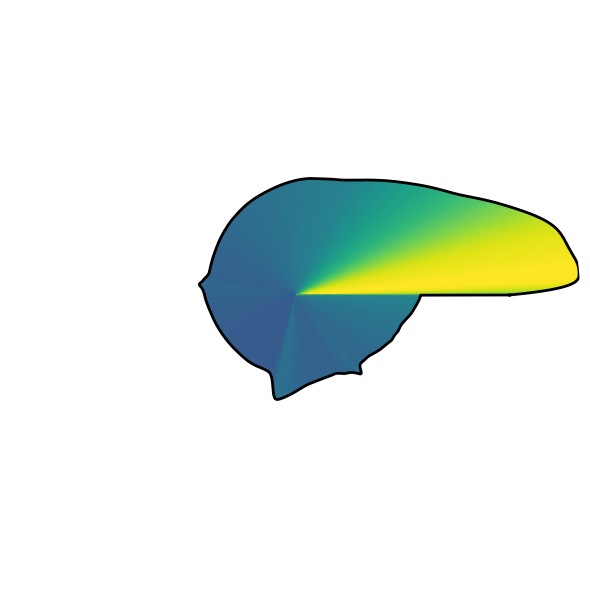

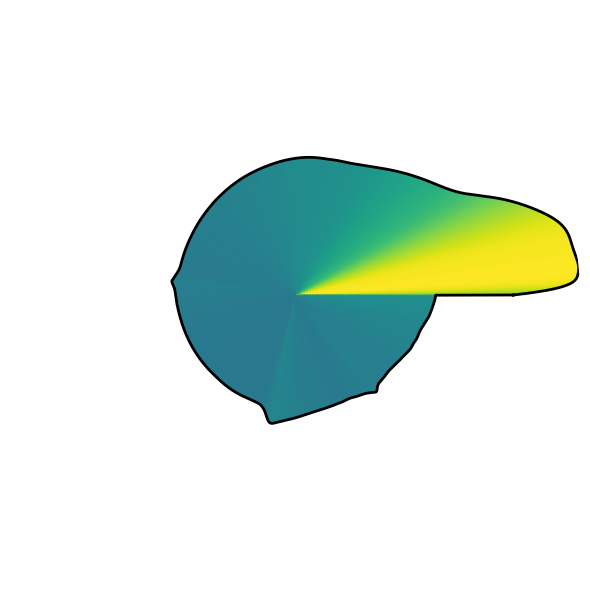

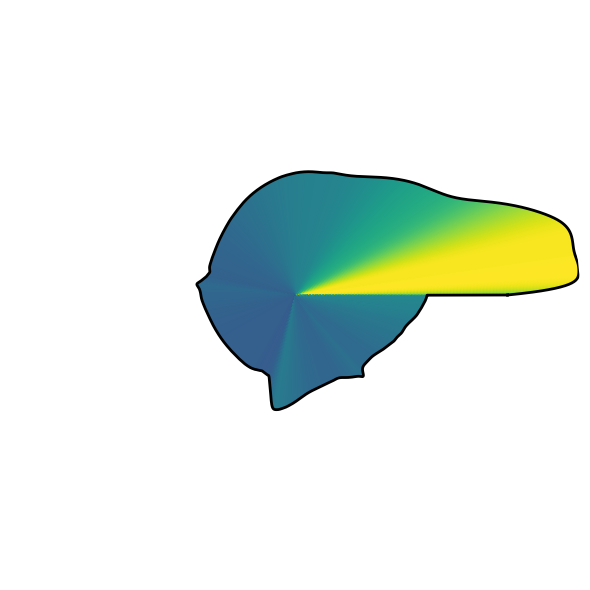

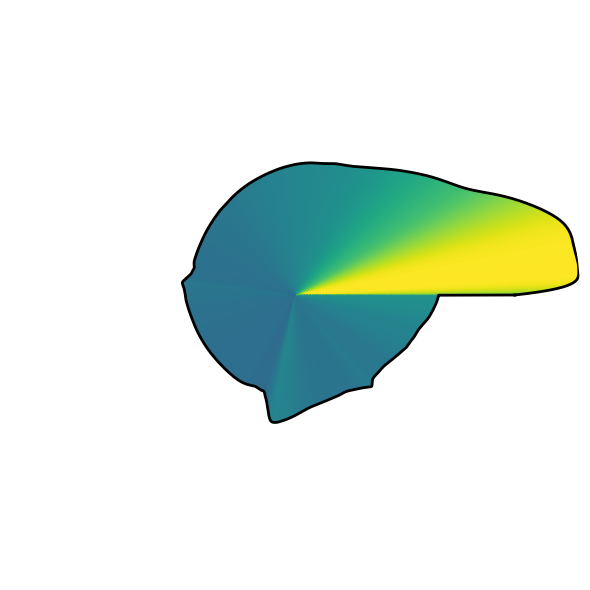

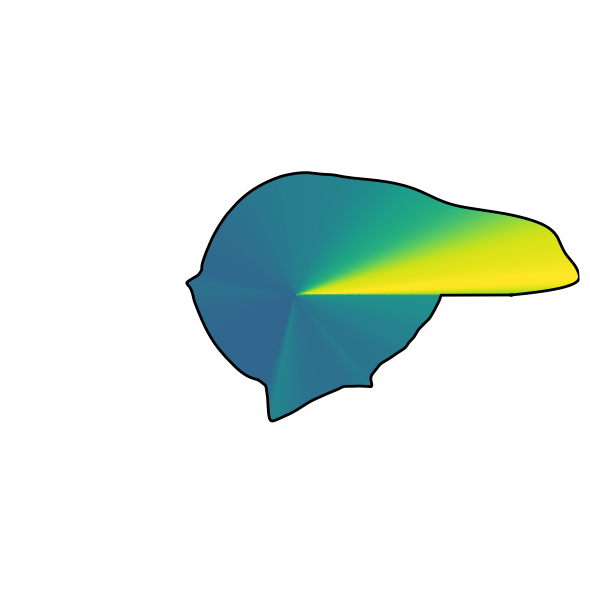

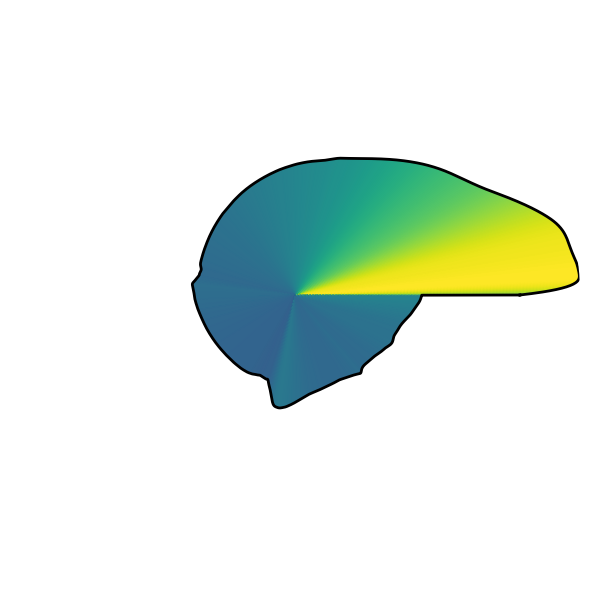

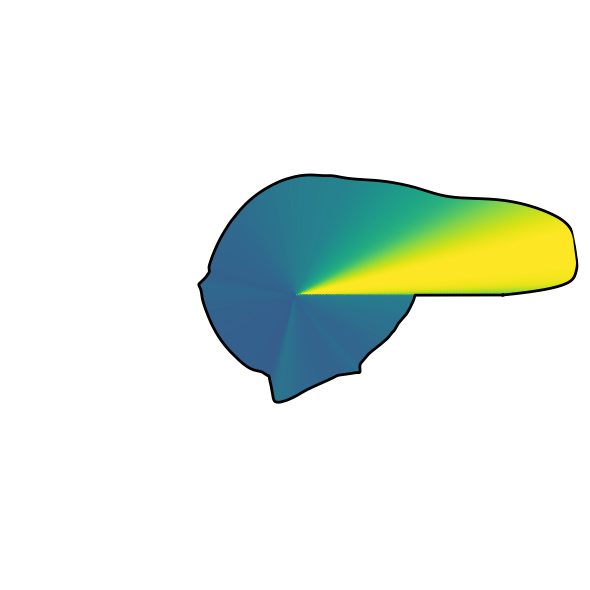

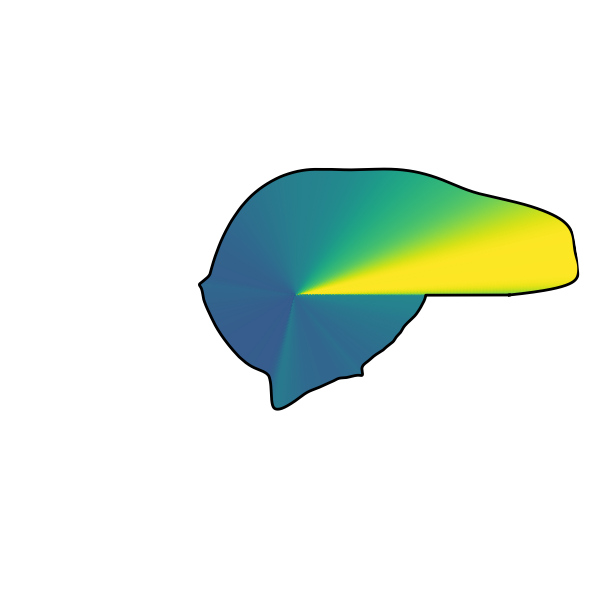

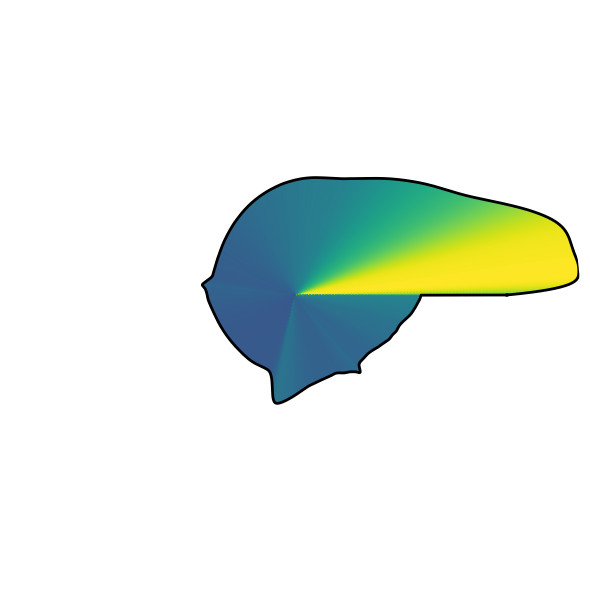

In [ ]:
# --- Output folder ---
output_dir = "spider_plots"
os.makedirs(output_dir, exist_ok=True)

# --- Generate & save plots ---
for i, row in df.iterrows():
    row_values = row.to_numpy()
    theta, values_norm, T, R, Z, masked = prepare_spider_data(row_values)
    save_path = os.path.join(output_dir, f"spider_plot_{i}.png")
    plot_spider(theta, values_norm, T, R, Z, save_path=save_path)

# --- Zip them ---
zip_filename = "spider_plots.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in os.listdir(output_dir):
        zipf.write(os.path.join(output_dir, file), arcname=file)

print(f"✅ All plots saved and zipped into {zip_filename}")